In [1]:
import json
import os
import random
import numpy as np
from utils import smiles_utils
from utils import polysmiles
from utils import base_units
import hoomd
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import foyer
from foyer import Forcefield
import py3Dmol
import ele
import warnings
import operator
from collections import namedtuple
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
units = base_units.base_units()

# Recovering Molar Mass Distributions

### Assuming Gaussian Distribution
In this cell, we assume the molar masses are normally distributed. Our goal is to take in any two of $M_n$, $M_w$, and the $PDI$ ($PDI=\frac{M_w}{M_n}$)

M_n: 50.0
M_w: 55.803129302993376
Recovered sigma: 290.1564651496688
Actual sigma: 301.0
76.47301319723567


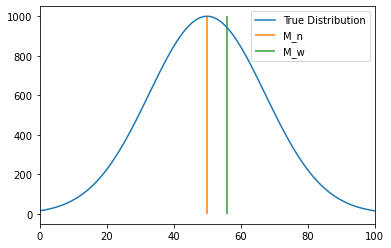

In [2]:

# With numerical integration, we don't recover exact sigma, but the distribution is close
x_max = 100
N = 1e3
sigma = 301.
x = np.linspace(0, x_max, round(N)+1)
y = N*np.exp(-(x-50.)**2/(2.*sigma))
M_n = np.sum(np.multiply(x,y))/np.sum(y)
# Notice if we replace the numerical integral with analytical form of M_w, we get exact agreement
M_w = np.sum(y*x**2)/np.sum(y*x)# (M_n**2 + sigma)/M_n
plt.plot(x, y, label='True Distribution')
plt.xlim(0, 100.)
plt.vlines(M_n, 0, N, 'C1', label='M_n')
plt.vlines(M_w, 0, N, 'C2', label='M_w')

def recovered_gauss_sigma(Mn, Mw):
    return Mn * (Mw - Mn)

def gauss(x, mu, sigma, N=1000):
    return N * np.exp(-(x - mu)**2 / (2. * sigma))

recovered_sig = recovered_gauss_sigma(M_n, M_w)

print(f'M_n: {M_n}\nM_w: {M_w}\nRecovered sigma: {recovered_sig}\nActual sigma: {sigma}')


y2 = gauss(x, mu=M_n, sigma=recovered_sig, N=N)
#plt.plot(x,y2, ':', lw=3, color='k', label='Recovered Distribution')
plt.legend()
plt.savefig('gaussian_mass_dist_true.svg')
mse = np.mean((y2-y)**2)
print(mse)
# TODO: Maybe play around with a Weibull distro and see how that compares

In [3]:
def weibull_k_expression(x, Mn, Mw):
    return (2. * x * gamma(2./x)) / gamma(1./x)**2 - (Mw / Mn)

def weibull_lambda_expression(Mn, k):
    return(Mn * k / gamma(1./k))

def recover_mass_dist(Mn=None, Mw=None, pdi=None, distribution='Gaussian'):
    '''This function takes in two of the three quantities [Mn, Mw, PDI],
       and fits either a Gaussian or Weibull distribution of molar masses to them.'''
    if distribution.lower() != 'gaussian' and distribution.lower() != 'weibull':
        raise(ValueError('Distribution must be either "gaussian" or "weibull".'))
    pdi_arg_sum = sum([x is not None for x in [pdi, Mn, Mw]])
    assert pdi_arg_sum >= 2, 'At least two of [pdi, M_n, M_w] must be given.'
    if pdi_arg_sum == 3:
        #special case, make sure that pdi = M_w / M_n
        assert pdi - (Mw/Mn) < 1e-5, 'PDI value does not match M_n and M_w values.'
    else:
        # need to recover one of M_w or M_n or pdi
        if Mn is None:
            Mn = Mw / pdi
        if Mw is None:
            Mw = pdi * Mn
        if pdi is None:
            pdi = Mw / Mn
    if distribution.lower() == 'gaussian':
        mean = Mn
        sigma = Mn * (Mw - Mn)
        return lambda x: np.exp(-(x-Mn)**2 / (2. * sigma))
    elif distribution.lower() == 'weibull':
        # get the shape parameter
        a = scipy.optimize.root(f1, args=(weib_M_n, weib_M_w), x0=1.)
        recovered_k = a['x']
        # get the scale parameter
        recovered_lambda = f2(Mn, recovered_k)
        return lambda x: ( recovered_k / recovered_lambda * (x / recovered_lambda) ** (recovered_k - 1) * np.exp(- (x / recovered_lambda) ** recovered_k) )

Now let's examine how close we actually get, as a function of $N$

[0.7058724306388201, 0.7358354448644935, 0.746001904047329, 0.7511188580538044, 0.7541998482585397, 0.7603862143493916, 0.7653587607673752, 0.7659817971558542, 0.766480461345451, 0.7665428090638243, 0.7665926895900458, 0.7665989248027029, 0.7666039129962168, 0.7666045365230392]


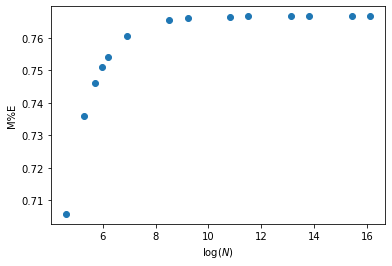

In [4]:
N_vals = [1e2, 2e2, 3e2, 4e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
mse_vals = []
sigma = 301.
for N in N_vals:
    N = round(N)
    x = np.linspace(0, x_max, N+1)
    y = N * np.exp(-(x - 50.)**2 / (2. * sigma))
    M_n = np.sum(np.multiply(x, y)) / np.sum(y)
    M_w = np.sum(y * x**2)/np.sum(y * x)# (M_n**2 +  sigma)/M_n
    recovered_sigma = M_n * (M_w - M_n)
    y2 = N * np.exp(-(x - 50.)**2 / (2. * recovered_sigma))
    mse_vals.append(np.mean( (100.*(np.abs(y2 - y)/N)) ))
print(mse_vals)
plt.plot(np.log(N_vals), mse_vals, 'o')
plt.xlabel('log($N$)')
plt.ylabel('M%E')
plt.savefig('gaussian_mse.svg')

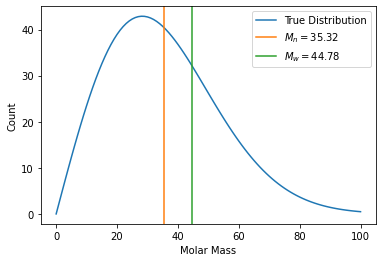

In [5]:
# try it with Weibull
def weib(x, shape=1., scale=1., coeff=1.):
    return coeff * ( shape / scale * (x / scale) ** (shape - 1) * np.exp(- (x / scale) ** shape) )
x = np.linspace(0., 100., 101)
scale = 40.
shape = 2.
plt.figure()
plt.plot(x, weib(x, shape, scale, coeff=2000), label='True Distribution')
y = weib(x, shape, scale)
weib_M_n = np.sum(x*y) / np.sum(y)
plt.axvline(x=weib_M_n, color="C1", label=f'$M_n={weib_M_n:.4}$')
weib_M_w = np.sum(x**2 * y) / np.sum(x*y)
plt.axvline(x=weib_M_w, color="C2", label=f'$M_w={weib_M_w:.4}$')

plt.xlabel('Molar Mass')
plt.ylabel('Count')
plt.legend()
plt.savefig('weibull_mass_dist_true.svg')

# now to recover the weibull params.
# we know M_n = lambda * Gamma(1+1/k)

the predicted value of lambda with k=2 is: 39.85564436657072 (should be ~40)
[2.02200446]
recovered lambda: [39.863006]


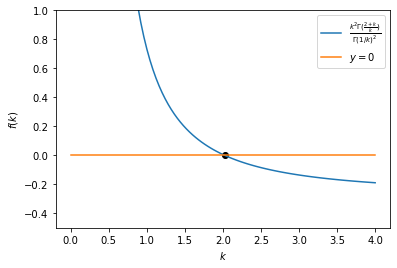

In [6]:
from scipy.special import gamma
import scipy.optimize
# expression for k, the shape factor ('x' here)
# the point where this function reaches zero is the correct k value
def f1(x, Mn, Mw):
    return (2. * x * gamma(2./x)) / gamma(1./x)**2 - (Mw / Mn)

def f2(Mn, k):
    return(Mn * k / gamma(1./k))

# if we *know* the k value, does our expression for lambda hold? (should be ~40)
print('the predicted value of lambda with k=2 is:', weib_M_n * 2. / gamma(0.5), '(should be ~40)')
# good

xrange = np.linspace(0,4,101)
plt.figure()
plt.plot(xrange,f1(xrange,weib_M_n, weib_M_w), label=r'$\frac{k^2 \Gamma(\frac{2+k}{k})}{\Gamma(1/k)^2}$')
plt.plot(xrange, np.zeros_like(xrange), label='$y=0$')
plt.ylim(-0.5,1)
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$f(k)$')

# try numeric solver
a=scipy.optimize.root(f1, args=(weib_M_n, weib_M_w), x0=1.)
recovered_k = a['x']
print(recovered_k)
# Now that we have the shape factor, plug it in to the other expression to solve for lambda
# lambda = M_n * k / Gamma(1/k)
recovered_lambda = f2(weib_M_n, recovered_k)
print('recovered lambda:', recovered_lambda)
plt.scatter(recovered_k, 0, color='k')
plt.savefig('k_numerical_solution.svg')

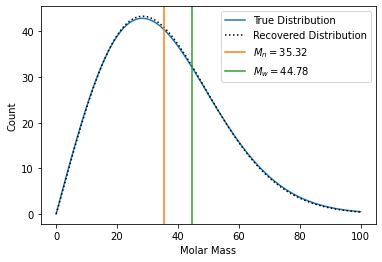

In [7]:
# plot recovered distro and compare
x = np.linspace(0., 100., 101)
scale = 40.
shape = 2.
plt.figure()
plt.plot(x, weib(x, shape, scale, coeff=2000), label='True Distribution')
plt.plot(x, weib(x, recovered_k, recovered_lambda, coeff=2000), label='Recovered Distribution', ls=':', color='k')
y = weib(x, shape, scale)
weib_M_n = np.sum(x*y) / np.sum(y)
plt.axvline(x=weib_M_n, color="C1", label=f'$M_n={weib_M_n:.4}$')
weib_M_w = np.sum(x**2 * y) / np.sum(x*y)
plt.axvline(x=weib_M_w, color="C2", label=f'$M_w={weib_M_w:.4}$')

plt.xlabel('Molar Mass')
plt.ylabel('Count')
plt.legend()
plt.savefig('weibull_mass_dist_recovered.svg')

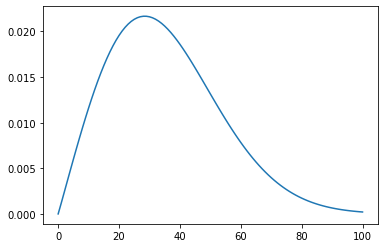

In [8]:
f = recover_mass_dist(Mn=weib_M_n, Mw=weib_M_w, pdi=None, distribution='weibull')
plt.plot(x, f(x))

## Comparing Distributions on Real Data

PDI: 1.0346695161194526
4.3825173904536125
0.665878628721637
    fjac: array([[-1.]])
     fun: array([4.4408921e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-2.60902411e-12])
       r: array([0.01022071])
  status: 1
 success: True
       x: array([6.26508615])
recovered k: [6.26508615]
recovered lambda: [4.7127628]


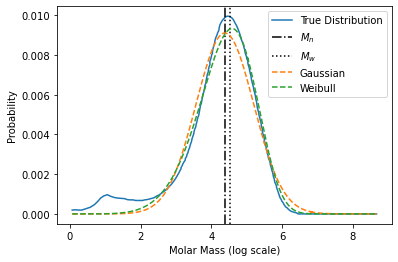

In [11]:
#TODO: now that this is working, pacakge this into a function

pekk_data_time_0 = np.genfromtxt('PEKK_No_Exposure.csv', delimiter=',')

# clean web plot digitizer data a bit

#pekk_data_time_0[:,1][np.where(pekk_data_time_0[:,1] < 5e-2 and pekk_data_time_0[:,0] > 1e6)] = 0

def filter_y(data_arr, high_cut=1e6, low_cut=5e-3):
    indices = np.where(data_arr[:,1] < low_cut)
    data_arr[indices, 1] = 0
    return data_arr

plt.figure()
data = filter_y(pekk_data_time_0)

x, y = np.log10(data[:,0]), data[:,1]
plt.plot(x,y/np.sum(y), label='True Distribution')

t0_Mn = np.sum(x*y) / np.sum(y)
t0_Mw = np.sum(x*x*y) / np.sum(x*y)
t0_pdi = t0_Mw / t0_Mn
print('PDI:', t0_pdi)
plt.axvline((t0_Mn), color='k', ls='-.', label='$M_n$')
plt.axvline((t0_Mw), color='k', ls=':', label='$M_w$')

print(t0_Mn)

# Now recover the distribution with both methods
# Gaussian
t0_sig = recovered_gauss_sigma(Mn=(t0_Mn), Mw=(t0_Mw))
print(t0_sig)
gauss_y = gauss((x), mu=(t0_Mn), sigma=t0_sig, N = 1)
plt.plot((x), gauss_y/np.sum(gauss_y), label='Gaussian', ls='--')

# Weibull 
a=scipy.optimize.root(lambda x, y, z: f1((x), y, z), args=((t0_Mn), (t0_Mw)), x0=1.)
print(a)
recovered_k = a['x']
print('recovered k:', recovered_k)
# Now that we have the shape factor, plug it in to the other expression to solve for lambda
# lambda = M_n * k / Gamma(1/k)
recovered_lambda = f2((t0_Mn), recovered_k)
print('recovered lambda:', recovered_lambda)
weib_y = weib(x, recovered_k, recovered_lambda)
plt.plot((x), weib_y/np.sum(weib_y), label='Weibull', ls='--')
plt.xlabel('Molar Mass (log scale)')
plt.ylabel('Probability')
plt.legend()

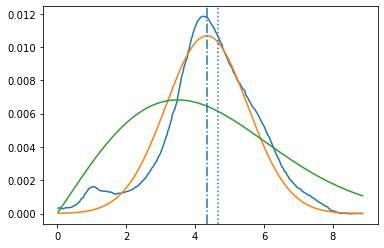

In [10]:
# Same as above, but with data after 2 hours of heating
pekk_data_time_240 = np.genfromtxt('240_Min.csv', delimiter=',')

x, y = np.log10(pekk_data_time_240[:,0]), pekk_data_time_240[:,1]

plt.plot(x, y/np.sum(y))

t240_Mn = np.sum(x*y) / np.sum(y)
t240_Mw = np.sum(x*x*y) / np.sum(x*y)

gauss_f = recover_mass_dist(Mn=t240_Mn, Mw=t240_Mw, pdi=None, distribution='gaussian')
weib_f = recover_mass_dist(Mn=t240_Mn, Mw=t240_Mw, pdi=None, distribution='weibull')

plt.plot(x, gauss_f(x)/np.sum(gauss_f(x)))
plt.plot(x, weib_f(x)/np.sum(weib_f(x)))

plt.axvline(t240_Mn, ls='-.')
plt.axvline(t240_Mw, ls=':')

In [13]:
class Simulation():
    def __init__(self,
                 system,
                 target_box=None,
                 r_cut = 1.2,
                 e_factor = 0.5,
                 tau = 0.1,
                 dt = 0.0001,
                 auto_scale = True,
                 ref_units = None,
                 mode = "gpu",
                 gsd_write = 1e4,
                 log_write = 1e3,
                 seed = 42
                 ):
        
        self.system = system 
        self.system_pmd = system.system_pmd # Parmed structure
        self.r_cut = r_cut
        self.e_factor = e_factor
        self.tau = tau
        self.dt = dt
        self.auto_scale = auto_scale
        self.ref_units = ref_units
        self.mode = mode
        self.gsd_write = gsd_write
        self.log_write = log_write
        self.seed = seed

        if ref_units and not auto_scale:
            self.ref_energy = ref_units['energy']
            self.ref_distance = ref_units['distance']
            self.ref_mass = ref_units['mass']           
        
        elif auto_scale and not ref_units: # Pulled from mBuild hoomd_simulation.py
            self.ref_mass = max([atom.mass for atom in self.system_pmd.atoms])
            pair_coeffs = list(set((atom.type,
                                    atom.epsilon,
                                    atom.sigma) for atom in self.system_pmd.atoms))
            self.ref_energy = max(pair_coeffs, key=operator.itemgetter(1))[1]
            self.ref_distance = max(pair_coeffs, key=operator.itemgetter(2))[2]
            
        self.reduced_target_L = self.system.target_L / self.ref_distance
        self.reduced_init_L = self.system_pmd.box[0] / self.ref_distance
        if target_box:
            self.target_box = target_box
        else:
            self.target_box = [self.reduced_target_L]*3
            
        self.log_quantities = [ 
        "temperature",
        "pressure",
        "volume",
        "potential_energy",
        "kinetic_energy",
        "pair_lj_energy",
        "bond_harmonic_energy",
        "angle_harmonic_energy"
        ]
    

    def quench(self, kT, n_steps, shrink_kT=10, shrink_steps=1e6):
        '''
        '''
        # Get hoomd stuff set:
        create_hoomd_simulation(self.system_pmd, self.ref_distance,
                                self.ref_mass, self.ref_energy,
                                self.r_cut, self.auto_scale)
        _all = hoomd.group.all()
        hoomd.md.integrate.mode_standard(dt=self.dt)
        integrator = hoomd.md.integrate.nvt(group=_all, kT=shrink_kT, tau=self.tau) # shrink temp
        integrator.randomize_velocities(seed=self.seed)
        
        # Set up shrinking box_updater:
        shrink_gsd = hoomd.dump.gsd("trajectories/traj-shrink.gsd",
                       period=self.gsd_write, group=_all, phase=0, overwrite=True)
        x_variant = hoomd.variant.linear_interp([(0, self.reduced_init_L),
                                                 (shrink_steps, self.target_box[0]*10)])
        y_variant = hoomd.variant.linear_interp([(0, self.reduced_init_L),
                                                 (shrink_steps, self.target_box[1]*10)])
        z_variant = hoomd.variant.linear_interp([(0, self.reduced_init_L),
                                                 (shrink_steps, self.target_box[2]*10)])
        box_updater = hoomd.update.box_resize(Lx = x_variant, Ly = y_variant, Lz = z_variant)
        
        # Run shrink portion of simulation:
        hoomd.run_upto(shrink_steps)
        shrink_gsd.disable()
        box_updater.disable()
        
        # Start new log and gsd files:
        hoomd.dump.gsd("trajectories/sim_traj.gsd",
                       period=self.gsd_write,
                       group=_all,
                       phase=0,
                       overwrite=True)
        hoomd.analyze.log("logs/sim_traj.log",
                          period=self.log_write,
                          quantities = self.log_quantities,
                          header_prefix="#",
                          overwrite=True, phase=0)
        # Run primary simulation:
        integrator.set_params(kT=kT)
        integrator.randomize_velocities(seed=self.seed)
        hoomd.run(n_steps+shrink_steps)
        
        
    def anneal(self,
              kT_init=None,
              kT_final=None,
              step_sequence=None,
              schedule=None,
              shrink_kT=10,
              shrink_steps=1e6
              ):
        
        if not schedule:
            temps = np.linspace(kT_init, kT_final, len(step_sequence))
            temps = [np.round(t, 1) for t in temps]
            schedule = dict(zip(temps, step_sequence))          
        
        # Get hoomd stuff set:
        create_hoomd_simulation(self.system_pmd, self.ref_distance,
                                self.ref_mass, self.ref_energy,
                                self.r_cut, self.auto_scale)
        _all = hoomd.group.all()
        hoomd.md.integrate.mode_standard(dt=self.dt)
        integrator = hoomd.md.integrate.nvt(group=_all, kT=shrink_kT, tau=self.tau) # shrink temp
        integrator.randomize_velocities(seed=self.seed)
        
        # Set up shrinking box_updater:
        shrink_gsd = hoomd.dump.gsd("trajectories/traj-shrink.gsd",
                       period=self.gsd_write, group=_all, phase=0, overwrite=True)
        x_variant = hoomd.variant.linear_interp([(0, self.reduced_init_L),
                                                 (shrink_steps, self.target_box[0]*10)])
        y_variant = hoomd.variant.linear_interp([(0, self.reduced_init_L),
                                                 (shrink_steps, self.target_box[1]*10)])
        z_variant = hoomd.variant.linear_interp([(0, self.reduced_init_L),
                                                 (shrink_steps, self.target_box[2]*10)])
        box_updater = hoomd.update.box_resize(Lx = x_variant, Ly = y_variant, Lz = z_variant)
        
        hoomd.run_upto(shrink_steps)
        print('Shrink step finished.')
        self.shrink_gsd.disable()
        box_updater.disable()
        print('Anneal Schedule:')
        print(schedule)
        print('-------------------------------')
        
        # Start annealing steps:
        anneal_gsd = hoomd.dump.gsd("trajectories/traj-anneal.gsd",
                                   period=self.gsd_write,
                                   group=_all,
                                   phase=0,
                                   overwrite=True)
        
        hoomd.analyze.log("logs/sim_traj.log",
                          period=self.log_write,
                          quantities = self.log_quantities,
                          header_prefix="#",
                          overwrite=True, phase=0)
        
        last_time_step = shrink_steps
        for kT in schedule:
            print('Running @ Temp = {}'.format(kT))
            n_steps = schedule[kT]
            print('Running for {} steps'.format(n_steps))
            integrator.set_params(kT=kT)
            integrator.randomize_velocities(seed=self.seed)
            hoomd.run(last_time_step + n_steps)
            last_time_step += n_steps
            print('Current time step = {}'.format(last_time_step))
            print('-----------------------------------------------')
            print()
        

class System():
    
    def __init__(self,
                 molecule,
                 para_weight,
                 density,
                 n_compounds=None,
                 polymer_lengths=None,
                 forcefield=None,
                 epsilon=1e-7,
                 sample_pdi=False,
                 pdi=None,
                 Mn=None,
                 Mw=None,
                 mass_dist_type='weibull',
                 remove_hydrogens=False,
                 assert_dihedrals=True,
                 seed=24
                ):
        self.molecule = molecule
        self.para_weight = para_weight
        self.density = density
        self.target_L = None
        self.remove_hydrogens = remove_hydrogens
        self.epsilon = epsilon
        self.forcefield = forcefield
        self.assert_dihedrals = assert_dihedrals
        self.seed = seed
        self.system_mass = 0
        self.para = 0 # keep track for now to check things are working, maybe keep?
        self.meta = 0
        
        if sample_pdi:
            if isinstance(n_compounds, list):
                raise TypeError('n_compounds should be an integer when sample_pdi is True.')
            pdi_arg_sum = sum([x is not None for x in [pdi, Mn, Mw]])
            assert pdi_arg_sum >= 2, 'At least two of [pdi, Mn, Mw] must be given.'
            if pdi_arg_sum == 3:
                #special case, make sure that pdi = Mw / Mn
                assert pdi - (Mw/Mn) < self.epsilon, 'PDI value does not match Mn and Mw values.'
            else:
                # need to recover one of Mw or Mn or pdi
                if Mn is None:
                    self.Mn = Mw / pdi
                if Mw is None:
                    self.Mw = pdi * Mn
                if pdi is None:
                    self.pdi = Mw / Mn # from here
                    
            # this returns a numpy.random callable set up with recovered parameters
            mass_distribution_dict = self._recover_mass_dist(mass_dist_type)
            self.mass_sampler = mass_distribution_dict['sampler']
            self.mass_distribution = mass_distribution_dict['functional_form']
            # TODO: make sure we don't sample any negative weights
            samples = np.round(self.mass_sampler(n_compounds)
                              ).astype(int)
            # get all unique lengths in increasing order
            self.polymer_lengths = sorted(list(set(samples)))
            # get count of each length
            self.n_compounds = [list(samples).count(x) for x in self.polymer_lengths]
            print(f'polymer_lengths: {self.polymer_lengths}, n_compounds: {self.n_compounds}')
            
        else: # Do some validation, get things in the correct data types
            if not isinstance(n_compounds, list):
                self.n_compounds = [n_compounds]
            else:
                self.n_compounds = n_compounds

            if not isinstance(polymer_lengths, list):
                self.polymer_lengths = [polymer_lengths]
            else:
                self.polymer_lengths = polymer_lengths
        
        if len(self.n_compounds) != len(self.polymer_lengths):
            raise ValueError('n_compounds and polymer_lengths should be equal length')
        
        self.system_mb = self._pack() # mBuild object before applying FF
        if self.forcefield:
            self.system_pmd = self._type_system() # parmed object after applying FF
        
    def _weibull_k_expression(self, x):
        return (2. * x * gamma(2./x)) / gamma(1./x)**2 - (self.Mw / self.Mn)
    
    def _weibull_lambda_expression(self, k):
        return self.Mn * k / gamma(1./k)
    
    def _recover_mass_dist(self, distribution='Gaussian'):
        '''This function takes in two of the three quantities [Mn, Mw, PDI],
           and fits either a Gaussian or Weibull distribution of molar masses to them.'''
        if distribution.lower() != 'gaussian' and distribution.lower() != 'weibull':
            raise(ValueError('Molar mass distribution must be either "gaussian" or "weibull".'))
        if distribution.lower() == 'gaussian':
            mean = self.Mn
            sigma = self.Mn * (self.Mw - self.Mn)
            return {'sampler': lambda N: np.random.normal(loc=mean, scale=sigma, size=N),
                    'functional_form': np.exp(-(x-Mn)**2 / (2. * sigma))}
        elif distribution.lower() == 'weibull':
            # get the shape parameter
            a = scipy.optimize.root(self._weibull_k_expression, args=(self.Mn, self.Mw), x0=1.)
            recovered_k = a['x']
            # get the scale parameter
            recovered_lambda = self._weibull_lambda_expression(self.Mn, recovered_k)
            return {'sampler': lambda N: recovered_lambda * np.random.weibull(recovered_k, size=N),
                    'functional_form': recovered_k / recovered_lambda * (x / recovered_lambda) ** (recovered_k - 1) * np.exp(- (x / recovered_lambda) ** recovered_k)}
        
    def _pack(self, box_expand_factor=5):
        random.seed(self.seed)
        mb_compounds = []
        for _length, _n in zip(self.polymer_lengths, self.n_compounds):
            for i in range(_n):
                polymer, sequence = build_molecule(self.molecule, _length,
                                        self.para_weight)

                mb_compounds.append(polymer)
                self.para += sequence.count('para')
                self.meta += sequence.count('meta')
            mass = _n * np.sum(ele.element_from_symbol(p.name).mass for p in polymer.particles())
            self.system_mass += mass # amu
        
        # Figure out correct box dimensions and expand the box to make the PACKMOL step faster
        # Will shrink down to accurate L during simulation
        L = self._calculate_L() * box_expand_factor
        system = mb.packing.fill_box(
            compound = mb_compounds,
            n_compounds = [1 for i in mb_compounds],
            box=[L, L, L],
            overlap=0.2,
            edge=0.9,
            fix_orientation=True)
        system.Box = mb.box.Box([L, L, L])
        return system
    
    
    def _type_system(self):
        if self.forcefield == 'gaff':
            forcefield = foyer.forcefields.load_GAFF()
        elif self.forcefield == 'opls':
            forcefield = foyer.Forcefield(name='oplsaa')
        
        typed_system = forcefield.apply(self.system_mb,
                                       assert_dihedral_params=self.assert_dihedrals)
        if self.remove_hydrogens: # not sure how to do this with Parmed yet
            removed_hydrogen_count = 0 # subtract from self.mass
            pass    
        return typed_system
    
    def _calculate_L(self):
        '''
        Calcualte the box length needed for entered density
        Right now, assuming cubic box
        Return L in nm (mBuild units)
        '''
        M = self.system_mass * units["amu_to_g"] # grams
        L = (M / self.density)**(1/3) # centimeters
        L *= units['cm_to_nm'] # convert cm to nm
        self.target_L = L # Used during shrink step
        return L

def build_molecule(molecule, length, para_weight):
    '''
    `build_molecule` uses SMILES strings to build up a polymer from monomers.
    The configuration of each monomer is determined by para_weight and the
    random_sequence() function.  
    Uses DeepSMILES behind the scenes to build up SMILES string for a polymer.
    
    Parameters
    ----------
    molecule : str
        The monomer molecule to be used to build up the polymer.
        Available options are limited  to the .json files in the compounds directory
        Use the molecule name as seen in the .json file without including .json
    length : int
        The number of monomer units in the final polymer molecule
    para_weight : float, limited to values between 0 and 1
        The relative amount of para configurations compared to meta.
        Passed into random_sequence() to determine the monomer sequence of the polymer.
        A 70/30 para to meta system would require a para_weight = 0.70
    
    Returns
    -------
    molecule_string_smiles : str
        The complete SMILES string of the polymer molecule
    '''
    f = open('compounds/{}.json'.format(molecule))
    mol_dict = json.load(f)    
    f.close()
    monomer_sequence = random_sequence(para_weight, length)
    molecule_string = '{}'

    for idx, config in enumerate(monomer_sequence):
        if idx == 0: # append template, but not brackets
            monomer_string = mol_dict['{}_template'.format(config)]
            if molecule == 'PEEK':
                monomer_string = "O" + monomer_string[1:]
            molecule_string = molecule_string.format(monomer_string)
            if len(monomer_sequence) == 1:
                molecule_string = molecule_string.replace('{}', '')
                continue

        elif idx == length - 1: # Don't use template for last iteration
            brackets = polysmiles.count_brackets(mol_dict['{}_deep_smiles'.format(config)])
            monomer_string = mol_dict['{}_deep_smiles'.format(config)]
            molecule_string = molecule_string.format(monomer_string, brackets)

        else: # Continue using template plus brackets
            brackets = polysmiles.count_brackets(mol_dict['{}_deep_smiles'.format(config)])
            monomer_string = mol_dict['{}_template'.format(config)]
            molecule_string = molecule_string.format(monomer_string, brackets)
    
    molecule_string_smiles = smiles_utils.convert_smiles(deep = molecule_string)
    compound = mb.load(molecule_string_smiles, smiles=True)
    return compound, monomer_sequence


def random_sequence(para_weight, length):
    '''
    random_sequence returns a list containing a random sequence of strings 'para' and 'meta'.
    This is used by build_molecule() to create a complete SMILES string of a molecule.
    
    Parameters:
    -----------
    para_weight : float, limited to values between 0 and 1
        The relative amount of para configurations compared to meta.
        Defined in build_molecule()
    length : int
        The number of elements in the random sequence.
        Defined in build_molecule()
    '''
    meta_weight = 1 - para_weight
    options = ['para', 'meta']
    probability = [para_weight, meta_weight]
    sequence = random.choices(options, weights=probability, k=length)
    return sequence

In [10]:
test_system = System(molecule="PEEK", para_weight=0.60,
                    density=1, n_compounds=[5], polymer_lengths=[5],
                    forcefield='gaff', assert_dihedrals=True)

sampling 10 molecular weights...
polymer_lengths: [19, 30, 31, 45, 62, 63, 64, 65, 68, 82], n_compounds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


FoyerError: Found multiple types for atom 3631 (6): ['cv', 'ce'].

In [12]:
simulation = Simulation(system=test_system)

In [ ]:
simulation.quench(kT=1.5, n_steps=1e6)

HOOMD-blue v2.9.2-15-g8c1194a45 CUDA (10.1) SINGLE SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 10/11/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
no CUDA-capable device is detected
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1710 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 3 exclusions             : 670
notice(2): Particles with 6 exclusions             : 90
notice(2): Particles with 7 exclusions             : 670
notice(2): Particles with 8 exclusions             : 180
notice(2): Particles with 9 exclusions             : 100
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded

In [ ]:
hoomd.dump.gsd()

In [ ]:
simulation.anneal(kT_init=2, kT_final=1, step_sequence=[1e5, 1e5, 1e5, 1e5])

In [ ]:
##############################################
##OLD STUFF
##############################################

In [ ]:
def build_system(packing='bcc'):
    '''
    Generate a simple LJ particle system using hoomd's create_lattice function
    packing 
    '''
    hoomd.context.initialize("")
    if packing == 'fcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.fcc(a=1.58)), n=6)
    elif packing == 'bcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.bcc(a=1.29)), n=6)
    hoomd.dump.gsd('{}_system.gsd'.format(packing), group = hoomd.group.all(), period=None, overwrite=True)
    return system

def hoomd_simulation(system, temp, tau):  
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
    lj.pair_coeff.set('A', 'A', alpha=1.0, epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.001)
    _all = hoomd.group.all()
    nvt = hoomd.md.integrate.nvt(group=_all, kT=temp, tau=tau)
    nvt.randomize_velocities(seed=23)
    hoomd.analyze.log(filename='{}-tau_out.log'.format(tau),
                      quantities=["time", "temperature", "potential_energy"],
                      period=100,
                      overwrite=True
                     )
    #hoomd.dump.gsd('tau-trajectory.gsd', period=5e3, group=_all, overwrite=True)
    hoomd.run(3e5)

# --------------------------------------------------------

PEEK:  
1 amu = 1.66054e-24 g  
1.32 g/cm^3  
1.32 g/nm^3  
C19H12O3  
monomer_amu = 288.302  

In [ ]:
def build_peek_system(num_mols, poly_length, density):
    '''
    This function uses mBuild's packing functionality to create a very low dense system of molecules
    to allow for easier packing. A short simulation is then ran using HoomD to shrink the system to the
    desired starting density.
    '''
    peek_poly_smi = polysmiles.poly_smiles('occccC=O)ccccOcc*c*ccc6)))))))cc6)))))))cc6',
                                      length=poly_length)
    peek_poly = mb.load(peek_poly_smi, smiles=True)
    
    mol_amu = poly_length * 288.302
    mol_grams = mol_amu * 1.66054e-24
    system_mass = mol_grams * num_mols
    edge_cm = (system_mass / density)**(1/3)
    edge_nm = edge_cm * 1e7

    init_box = mb.Box([edge_nm*5]*3)
    system = mb.fill_box(peek_poly, num_mols, init_box)
    
    GAFF = foyer.forcefields.load_GAFF()
    system_pmd = GAFF.apply(system)
    create_hoomd_simulation(system_pmd, r_cut=1.2, auto_scale=True)
    forces = [f for f in hoomd.context.current.forces 
                if not isinstance(f, hoomd.md.charge.pppm)]
    
    hoomd.context.current.forces = forces
    _all = hoomd.group.all()
    hoomd.md.integrate.mode_standard(dt=0.0001)
    integrator = hoomd.md.integrate.nvt(group=_all, kT=2.0, tau=0.1)
    hoomd.dump.gsd("trajectories/start-shrink.gsd", period=None, group=_all, overwrite=True)
    hoomd.dump.gsd("trajectories/traj-shrink.gsd", period=1e5, group=_all, phase=0, overwrite=True)
    integrator.randomize_velocities(seed=42);

    hoomd.update.box_resize(L = hoomd.variant.linear_interp([(0,edge_nm*50), (1e6,edge_nm*10)], zero=0))
    hoomd.run(1e6)
    gsd_restart = hoomd.dump.gsd("trajectories/out-shrink.gsd", period=None, group=_all, overwrite=True)
    gsd_restart.write_restart()

In [ ]:
build_peek_system(num_mols=20, poly_length=5, density=1.2)

# -------------------------------------------------------------------------

In [ ]:
# Smiles Strings
'''
DEEPSMILES:
PEEK-para = "occccoccccC=O)cccccc6)))))))cc6)))))))cc6"
PEEK-meta = "occcoccccC=O)cccccc6)))))))cc6)))))))ccc6"
PEKK-para = "ccccoccccC=o)ccccC=o))cc6)))))))cc6)))))))cc6"
PEKK-meta = "ccccoccccC=o)cccC=o))ccc6)))))))cc6)))))))cc6"

SMILES:
PEEK-para = "oc3ccc(oc2ccc(C(=O)c1ccccc1)cc2)cc3"
PEEK-meta = "oc3cc(oc2ccc(C(=O)c1ccccc1)cc2)ccc3"
PEKK-para = "c3ccc(oc2ccc(C(=o)c1ccc(C=o)cc1)cc2)cc3"
PEKK-meta = "c3ccc(oc2ccc(C(=o)c1cc(C=o)ccc1)cc2)cc3"
'''


# DeepSMILES with bonded atom indicated
'''
PEEK Para Bonded:
"occccoccccC=O)cc*c*ccc6)))))))cc6)))))))cc6"
"occccoccccC=O)ccc*c*cc6)))))))cc6)))))))cc6"
"occccoccccC=O)cccc*c*c6)))))))cc6)))))))cc6"

PEEK Meta Bonded:
"occcoccccC=O)ccc*c*cc6)))))))cc6)))))))ccc6"
"occcoccccC=O)cc*c*ccc6)))))))cc6)))))))ccc6"
"occcoccccC=O)cccc*c*c6)))))))cc6)))))))ccc6"

PEKK Para Bonded
"ccccoccccC=o)cccc*C*=o))cc6)))))))cc6)))))))cc6"
PEKK Meta Bonded
"ccccoccccC=o)ccc*C*=o))ccc6)))))))cc6)))))))cc6"
'''


# Build up dicts and save to json file
'''
PEKK_dict = {}

PEKK_dict['para_deep_smiles'] = "ccccoccccC=o)ccccC=o))cc6)))))))cc6)))))))cc6"
PEKK_dict['meta_deep_smiles'] = "ccccoccccC=o)cccC=o))ccc6)))))))cc6)))))))cc6"
PEKK_dict['para_smiles'] = "c3ccc(oc2ccc(C(=o)c1ccc(C=o)cc1)cc2)cc3"
PEKK_dict['meta_smiles'] = "c3ccc(oc2ccc(C(=o)c1cc(C=o)ccc1)cc2)cc3"
PEKK_dict['para_template'] = "ccccoccccC=o)cccc*C*=o))cc6)))))))cc6)))))))cc6"
PEKK_dict['meta_template'] = "ccccoccccC=o)ccc*C*=o))ccc6)))))))cc6)))))))cc6"
PEKK_dict['monomer_mass'] = 302.329


PEEK_dict = {}

PEEK_dict['para_deep_smiles'] = "occccoccccC=O)cccccc6)))))))cc6)))))))cc6"
PEEK_dict['meta_deep_smiles'] = "occcoccccC=O)cccccc6)))))))cc6)))))))ccc6"
PEEK_dict['para_smiles'] = "oc3ccc(oc2ccc(C(=O)c1ccccc1)cc2)cc3"
PEEK_dict['meta_smiles'] = "oc3cc(oc2ccc(C(=O)c1ccccc1)cc2)ccc3"
PEEK_dict['para_template'] = "occccoccccC=O)ccc{}{}ccc6)))))))cc6)))))))cc6"
PEEK_dict['meta_template'] = "occcoccccC=O)cccc{}{}cc6)))))))cc6)))))))ccc6"
PEEK_dict['monomer_mass'] = 288.302



file_name = 'compounds/PEKK.json'
with open(file_name, 'w') as fp:
    json.dump(PEKK_dict, fp)
'''